In [1]:
import os
import yaml
import time
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from linearqmml.parsing import LammpsParser

from linearqmml.regression import fused_ridge_regression
from linearqmml.regression import ridge_regression
from linearqmml.regression import cross_validation

from linearqmml.plotting import plot_distance_histogram
from linearqmml.plotting import plot_representations
from linearqmml.plotting import plot_morse_performance

from linearqmml.utils import get_morse_potential
from linearqmml.utils import tqdm_wrap

In [2]:
from linearqmml.smearing import triangle_pdf
from linearqmml.smearing import triangle_cdf

In [3]:
from linearqmml.smearing import get_bin_edges
from linearqmml.smearing import RealspaceHandler
from linearqmml.smearing import distance_matrix_periodic

# Parsing

In [4]:
import linearqmml
package_root = '/'.join(linearqmml.__file__.split('/')[:-2])
example_dir = package_root + '/examples'
assert os.path.isdir(example_dir)

run_stem = 'copper_liquid'
element_symbols = ['Cu']
element_aliases = {'1': 'Cu'}

parsing_handler = LammpsParser(root=example_dir,
                               stem=run_stem, 
                               element_symbols=element_symbols,
                               element_aliases=element_aliases)
print(LammpsParser.__doc__)
print(LammpsParser.__init__.__doc__)


    Parse LAMMPS .xyz and dumps. Supports serialization to yaml.

    Suggest usage:
    1. process_dump()
    2. flatten_entries() to retrieve keys, ase Atoms objects, and energies
    

        Args:
            root (str): Path to working directory.
            stem (str): Prefix for dataset filenames.
            element_symbols (list): List of element symbols (str).
            element_aliases (dict): Optional mapping of aliases
                for element symbols. LAMMPS users typically use integers
                as element identifiers in inputs/outputs. Defaults to
                integer: symbol mapping based on alphabetical sorting plus
                symbol: symbol identity mapping.
        


In [5]:
filename = '{}/{}.dump'.format(parsing_handler.root, parsing_handler.stem)
parsing_handler.process_dump(filename=filename)
print(LammpsParser.process_dump.__doc__)

100%|██████████| 2601/2601 [00:01<00:00, 1635.48it/s]


        Process custom LAMMPS dump file. Obtain by LAMMPS commands:
            "compute peratom all pe/atom"
            "compute pe all reduce sum c_perat"
            "dump fix_dump all custom 1 ${root}/${stem}.dump id x y z c_perat"

        Args:
            filename: Optional filename. Defaults to [root]/[stem].dump
        


In [6]:
local=False
indices = None
key_subset = None
flattened_entries = parsing_handler.flatten_entries(local=local,
                                                    indices=indices,
                                                    key_subset=key_subset)
keys, geometries, energies = flattened_entries
print(LammpsParser.flatten_entries.__doc__)


        Flattens entries into lists e.g. for machine learning.

        Args:
            local (bool): uses list of energies if available instead of sum.
            indices (list): optional subset of integers for slicing the
                flattened list of keys.
            key_subset (list): optional list of keys with which to take subset.

        Returns:
            keys (list): Entry names. Often simply the timesteps from LAMMPS.
            geometries (list): List of ase Atoms objects.
            energies (list): List of energies or lists of local energies.
        


In [7]:
df = pd.DataFrame(columns=['Energy'], index=keys, data=energies)
df['Geometry'] = geometries
df.tail()

,Energy,Geometry
259600,-320.92193,"(Atom('Cu', [5.727547529418534, 7.024117529418..."
259700,-317.78178,"(Atom('Cu', [5.5855575294185345, 7.19925752941..."
259800,-320.83003,"(Atom('Cu', [5.329797529418534, 7.255487529418..."
259900,-322.28102,"(Atom('Cu', [5.320797529418535, 7.350327529418..."
260000,-324.74018,"(Atom('Cu', [5.055277529418534, 7.416527529418..."


# Regression Demo


In [8]:
n_bins = 50
r_min = 1.5
r_max = 5.0

sigma_test = 0.1  # width (radius) of broadening
characteristic_bin_width = (r_max - r_min) / n_bins
sigma_factor = sigma_test/characteristic_bin_width

In [9]:
power = 1
handler_r = RealspaceHandler(sigma_factor=sigma_factor,
                             lower_bound=[r_min],
                             upper_bound=[r_max],
                             resolutions=[n_bins],
                             transform_power=power)
print(RealspaceHandler.__init__.__doc__)


        Args:
            sigma_factor (float): smearing parameter to be multiplied by the
                characteristic bin width for each dimension.
            lower_bound (list): list of lower bound (floats) per dimension.
            upper_bound (list): list of upper bound (floats) per dimension.
            resolutions (list): list of number of bins (int) per dimension.
            transform_power (int): scaling power for weighting bin widths.
        


In [10]:
repr_columns = ['x_{}'.format(i) for i in range(n_bins)]
repr_df = pd.DataFrame(columns=repr_columns)
n = 100
entries = sorted(zip(keys, geometries), key=lambda x: int(x[0]))[:n]

for key, geometry in tqdm_wrap(entries):
    representation = handler_r.describe_1d(geometry)
    repr_df.loc[key] = representation

100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


In [11]:
frac_train = 0.8
n_folds = 5
n_train = int(len(repr_df) * frac_train)

x_train = repr_df.iloc[:n_train].values
y_train = energies[:n_train]

x_test = repr_df.iloc[n_train:].values
y_test = energies[n_train:len(repr_df)]

In [12]:
res = pd.DataFrame(columns=['Train RMSE', 'CV RMSE'])
for lambda_ in tqdm_wrap(np.logspace(-3, 3, 61)):
    train_rmse, cv_rmse = cross_validation(ridge_regression,
                                           x_train,
                                           y_train,
                                           lambda_=lambda_)
    res.loc[lambda_] = [train_rmse, cv_rmse]

100%|██████████| 61/61 [00:00<00:00, 347.67it/s]


In [13]:
lambda_ = res['CV RMSE'].idxmin()
coefficients, predictions, input_mean = ridge_regression(x_train, 
                                                         y_train, 
                                                         lambda_=lambda_)
print(ridge_regression.__doc__)


    Solves the Ax=y with ridge regression
    x = np.linalg.inv(A.T*A + lambda * I)*A.T*y

    Args:
        A (np.ndarray): representations.
        y (np.ndarray): energies.
        lambda_ (float): regularization parameter.

    Returns:
        beta (np.ndarray): coefficients.
        y_beta (np.ndarray): predicted energies.
        A_mean (np.ndarray): average representation; used for centering.
    


3.908671987147066 % error


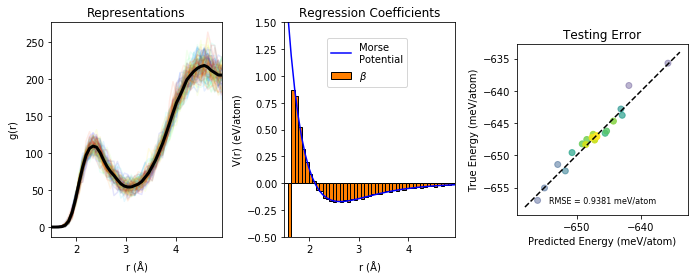

In [14]:
test_predictions = np.dot(coefficients, x_test.T)

r_range = handler_r.bin_edges[0]
plot_morse_performance(coefficients, 
                       test_predictions, 
                       y_test, 
                       repr_df.values, 
                       r_range)
plt.show()

# Weighted Regression Demo


In [15]:
power = -1
handler_inv = RealspaceHandler(sigma_factor=sigma_factor,
                               lower_bound=[r_min],
                               upper_bound=[r_max],
                               resolutions=[n_bins],
                               transform_power=power)

In [16]:
repr_columns = ['x_{}'.format(i) for i in range(n_bins)]
repr_df = pd.DataFrame(columns=repr_columns)

n = 100
entries = sorted(zip(keys, geometries), key=lambda x: int(x[0]))[:n]

for key, geometry in tqdm_wrap(entries):
    representation = handler_inv.describe_1d(geometry)
    repr_df.loc[key] = representation

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


In [17]:
frac_train = 0.8
n_train = int(len(repr_df) * frac_train)

x_train = repr_df.iloc[:n_train].values
y_train = energies[:n_train]

x_test = repr_df.iloc[n_train:].values
y_test = energies[n_train:len(repr_df)]

In [18]:
res = pd.DataFrame(columns=['Train RMSE', 'CV RMSE'])
for lambda_ in tqdm_wrap(np.logspace(-3, 3, 61)):
    train_rmse, cv_rmse = cross_validation(ridge_regression,
                                           x_train,
                                           y_train,
                                           lambda_=lambda_)
    res.loc[lambda_] = [train_rmse, cv_rmse]

100%|██████████| 61/61 [00:00<00:00, 360.53it/s]


5.037332120493626 % error


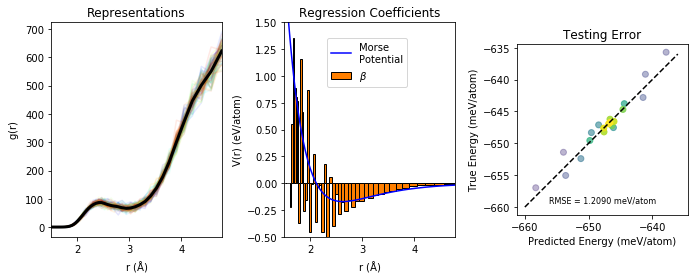

In [19]:
lambda_ = res['CV RMSE'].idxmin()
coefficients, predictions, input_mean = ridge_regression(x_train, 
                                                         y_train, 
                                                         lambda_=lambda_)
test_predictions = np.dot(coefficients, x_test.T)

r_range = handler_inv.bin_edges[0]
plot_morse_performance(coefficients, 
                       test_predictions, 
                       y_test, 
                       repr_df.values, 
                       r_range)
plt.show()

# Fused Regression Demo

In [20]:
index = pd.MultiIndex(levels=[[],[]],
                      codes=[[],[]],
                     names=['lambda', 'eta'])
res = pd.DataFrame(index=index, columns=['Train RMSE', 'CV RMSE'])

In [24]:
from itertools import product
lambda_space = np.logspace(-3, 3, 31)
eta_space = np.logspace(-3, 3, 31)
combinations = list(product(lambda_space, eta_space))
for lambda_, eta in tqdm_wrap(combinations):
    train_rmse, cv_rmse = cross_validation(fused_ridge_regression,
                                           x_train,
                                           y_train,
                                           lambda_=lambda_)
    res.loc[(lambda_, eta), :] = [train_rmse, cv_rmse]

100%|██████████| 961/961 [00:02<00:00, 412.06it/s]


In [25]:
lambda_, eta = res.index[np.argmin(res['CV RMSE'].values)]
regression_results = fused_ridge_regression(x_train, 
                                            y_train, 
                                            lambda_=lambda_,
                                            eta=eta)
coefficients, predictions, input_mean = regression_results

4.523382741941705 % error


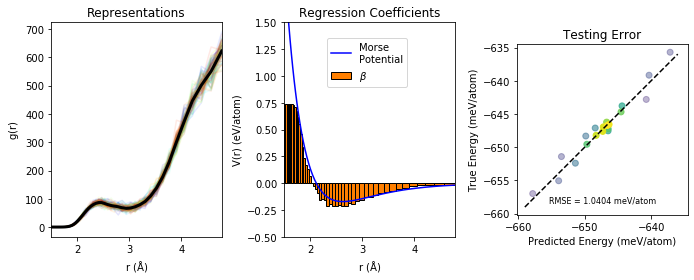

In [26]:
test_predictions = np.dot(coefficients, x_test.T)

r_range = handler_inv.bin_edges[0]
fig, ax  = plot_morse_performance(coefficients, 
                                  test_predictions, 
                                  y_test, 
                                  repr_df.values, 
                                  r_range)